### Language Modeling With an RNN
Data:<br>
https://www.kaggle.com/competitions/nlp-getting-started

### LSTM model

In [1]:
import os
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
random_state = 42
tf.random.set_seed(random_state)
np.random.seed(random_state)

# make labels consistent by majority voting and drop duplicates
do_majority_vote_label = True
# expand contractions
do_expand_contractions = True
# clean tweets
do_clean_tweets = True

# model type: 'SimpleRNN', 'LSTM', 'GRU'
model_type = 'LSTM'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# load data
train = pd.read_csv('drive/MyDrive/input/nlp-getting-started/train.csv')
test = pd.read_csv('drive/MyDrive/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('drive/MyDrive/input/nlp-getting-started/sample_submission.csv')

In [3]:
# relabel inconsistent tweets based on majority voting
# then drop duplicates (keeping first)
if do_majority_vote_label:
  # check # of inconsistent labels
  print(np.sum(train.groupby('text')['target'].nunique()>1)) 
  train['mislabeled'] = train.groupby('text')['target'].transform('nunique')>1
  # majority vote
  train['target_relabel'] = train.groupby('text')['target'].transform('mean')
  train['target_relabel'] = train['target_relabel'].apply(lambda x: int(x>=0.5))
  # check # of inconsistent labels after relabeling
  print(np.sum(train.groupby('text')['target_relabel'].nunique()>1)) 
  # verified only mislabeled are changed
  print(train[train['target']!=train['target_relabel']]['mislabeled'].value_counts()) 
  train.drop_duplicates(subset='text', keep='first', inplace=True)

18
0
True    22
Name: mislabeled, dtype: int64


In [4]:
# expand contractions
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

if do_expand_contractions:
  train['text'] = train['text'].apply(expand_contractions)
  test['text'] = test['text'].apply(expand_contractions)

In [5]:
# make text lowercase, remove text in square brackets, remove links, remove punctuation,
# remove words containing numbers
def clean_text(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

# remove emojis
def remove_emoji(text):
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

if do_clean_tweets:
  train['text'] = train['text'].apply(lambda x: clean_text(x))
  test['text'] = test['text'].apply(lambda x: clean_text(x))
  train['text']=train['text'].apply(lambda x: remove_emoji(x))
  test['text']=test['text'].apply(lambda x: remove_emoji(x))

In [6]:
# data after cleaning, if applicable
train.head()

,id,keyword,location,text,target,mislabeled,target_relabel
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,False,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,False,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,False,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,False,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,False,1


In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan


In [8]:
# define X_train, y_train, X_test
X_train = train['text'].to_numpy()
print('labels:')
if do_majority_vote_label:
  y_train = train['target_relabel'].to_numpy()
  print(train['target_relabel'].value_counts())
else:
  y_train = train['target'].to_numpy()
  print(train['target'].value_counts())
X_test = test['text'].to_numpy()
print('\nX_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)

labels:
0    4302
1    3201
Name: target_relabel, dtype: int64

X_train shape: (7503,) y_train shape: (7503,)
X_test shape: (3263,)


In [9]:
# use tokenizer to vectorize text corpus, turning text to sequence of int
# 0 is reserved and not assigned 
# first, update internal vocabulary based on a list of texts
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=True)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
vocab_length = len(tokenizer.word_index)+1
print('vocab length:', vocab_length)

vocab length: 21166


In [10]:
# find max number of tokens
X_train_maxlen = max(X_train, key=lambda x: len(word_tokenize(x)))
X_train_maxlen = len(word_tokenize(X_train_maxlen))
print('maxlen of tokenized X_train:', X_train_maxlen)
# transform text to a sequence of integers then pad to max length
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=tokenizer.texts_to_sequences(X_train),
    maxlen=X_train_maxlen, dtype='int32', padding='post',)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=tokenizer.texts_to_sequences(X_test),
    maxlen=X_train_maxlen, dtype='int32', padding='post',)
print('X_train_padded shape:', X_train_padded.shape)
print('X_test_padded shape:', X_test_padded.shape)

maxlen of tokenized X_train: 40
X_train_padded shape: (7503, 40)
X_test_padded shape: (3263, 40)


In [11]:
# GloVe word vectors trained on Wikipedia, 100d version
embeddings_index = {}
glove_fn = 'glove.6B.100d.txt'
with open(os.path.join('drive/MyDrive/input/glove/', glove_fn), 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print(f'{len(embeddings_index)} word vectors in the GloVe library')

400000 word vectors in the GloVe library


In [12]:
# get embedding matrix
embedding_dim = int(glove_fn.split('6B.')[1].split('d')[0])
# initialize with zeros
embedding_matrix = np.zeros((vocab_length, embedding_dim))
# update embedding matrix: 
# store glove word vector representation in embedding matrix if word is in embedding index
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # words not found in embedding index will be zeros
        embedding_matrix[index] = embedding_vector
print('embedding matrix shape:', embedding_matrix.shape)

embedding matrix shape: (21166, 100)


In [13]:
# use GloVe embedding as embedding layer in model
# construct LSTM model
if model_type=='LSTM':
  model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                              weights=[embedding_matrix], input_length=X_train_maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=X_train_maxlen, 
                                                      recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=X_train_maxlen, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=X_train_maxlen, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),                                    
  ])

# construct GRU model
elif model_type=='GRU':
  model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                              weights=[embedding_matrix], input_length=X_train_maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=X_train_maxlen, 
                                                      recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=X_train_maxlen, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=X_train_maxlen, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),                                    
  ])

# construct SimpleRNN model
elif model_type=='SimpleRNN':

  model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                              weights=[embedding_matrix], input_length=X_train_maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=X_train_maxlen, 
                                                      recurrent_dropout=0.2, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=X_train_maxlen, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=X_train_maxlen, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),                                    
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2116600   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 80)            45120     
_________________________________________________________________
global_max_pooling1d (Global (None, 80)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 80)                320       
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0

In [14]:
# callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_'+model_type+'.h5', monitor='val_loss',
                                                verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, 
                                                 verbose=1, min_lr=0)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# compile and fit
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train_padded, y=y_train, batch_size=None, epochs=50, verbose=2,
                    validation_split=0.2, callbacks = [reduce_lr, es, checkpoint])

Epoch 1/50
188/188 - 14s - loss: 0.7061 - accuracy: 0.6345 - val_loss: 0.5866 - val_accuracy: 0.7768

Epoch 00001: val_loss improved from inf to 0.58663, saving model to model_LSTM.h5
Epoch 2/50
188/188 - 9s - loss: 0.5536 - accuracy: 0.7394 - val_loss: 0.4902 - val_accuracy: 0.7855

Epoch 00002: val_loss improved from 0.58663 to 0.49025, saving model to model_LSTM.h5
Epoch 3/50
188/188 - 9s - loss: 0.4992 - accuracy: 0.7822 - val_loss: 0.4441 - val_accuracy: 0.8108

Epoch 00003: val_loss improved from 0.49025 to 0.44411, saving model to model_LSTM.h5
Epoch 4/50
188/188 - 9s - loss: 0.4572 - accuracy: 0.8046 - val_loss: 0.4479 - val_accuracy: 0.8081

Epoch 00004: val_loss did not improve from 0.44411
Epoch 5/50
188/188 - 9s - loss: 0.4295 - accuracy: 0.8276 - val_loss: 0.4194 - val_accuracy: 0.8108

Epoch 00005: val_loss improved from 0.44411 to 0.41941, saving model to model_LSTM.h5
Epoch 6/50
188/188 - 9s - loss: 0.4052 - accuracy: 0.8341 - val_loss: 0.4330 - val_accuracy: 0.8061

Ep

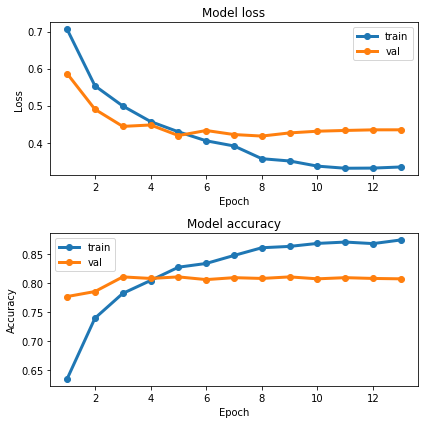

In [15]:
# plot history
df_plot = pd.DataFrame(history.history)
fig, axs = plt.subplots(2,1, figsize=(6,6))
axs[0].plot(df_plot.index+1, df_plot['loss'], '-o', lw=3, label='train')
axs[0].plot(df_plot.index+1, df_plot['val_loss'], '-o', lw=3, label='val')
axs[0].set(title='Model loss', ylabel='Loss')
axs[1].plot(df_plot.index+1, df_plot['accuracy'], '-o', lw=3, label='train')
axs[1].plot(df_plot.index+1, df_plot['val_accuracy'], '-o', lw=3, label='val')
axs[1].set(title='Model accuracy', ylabel='Accuracy')
axs[0].set_ylim([None, None])
axs[1].set_ylim([None, None])
for ax in axs:
  ax.set_xlabel('Epoch')
  ax.legend()
fig.tight_layout()
plt.show()
fig.savefig('train_hist_'+model_type+'.pdf', format='pdf', bbox_inches='tight')

In [16]:
# reload best weights and evaluate model
model.load_weights('model_'+model_type+'.h5')
model.evaluate(X_train_padded, y_train)

235/235 [==============================] - 2s 9ms/step - loss: 0.3164 - accuracy: 0.8666


[0.3163630962371826, 0.8665866851806641]

In [17]:
# predict
y_pred = model.predict(X_test_padded)
y_pred = (y_pred>=0.5).astype(int).flatten()
# prep submission
submission = sample_submission.copy()
submission['target'] = y_pred
submission.to_csv('submission_'+model_type+'.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
